In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from sklearn.preprocessing import OneHotEncoder

In [8]:
np.random.seed(42)
n_samples = int( 10e4 )
df = pd.DataFrame({
    'x1': 10 + 3 * np.random.randn(n_samples),
    'x2': 20 + 3 * np.random.randn(n_samples),
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = np.cos(df['x1']) + np.sin(df['x2']) + \
    np.random.randn(n_samples) * 0.5 + \
    np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

# x1_trans = FlatRampTransformer(
#     knots = list( np.arange(4, 16, 1 ) ),
#     include_bias=True
# )

# x2_trans = FlatRampTransformer(
#     knots = list( np.arange(14, 26, 1 ) ),
#     include_bias=True
# )

# train_df = np.concatenate([
#     x1_trans.fit_transform(df['x1']),
#     x2_trans.fit_transform(df['x2']),
#     pd.get_dummies(df['x3'], prefix='x3') * 1
# ], axis=1)

# train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
#                         + x2_trans.get_feature_names_out().tolist()
#                         + [ 'x3_' + str(cat) for cat in df['x3'].cat.categories.tolist() ])

In [10]:
feature_config = {
    'x1': FlatRampTransformer( knots=list( np.arange(4, 16, 1 ) ), include_bias=True ),
    'x2': FlatRampTransformer( knots=list( np.arange(14, 26, 1 ) ), include_bias=True ),
    'x3': OneHotEncoder( drop=None )
}

In [13]:
dfs = []
col_names = []
feature_groups = {}

for colname, transformer in feature_config.items():
    if isinstance(transformer, OneHotEncoder):
        df_transformed = transformer.fit_transform(df[[colname]]).toarray()
    else:
        df_transformed = transformer.fit_transform(df[colname])
    dfs.append(df_transformed)
    col_names.extend(transformer.get_feature_names_out())
    feature_groups[colname] = transformer.get_feature_names_out().tolist()
    
train_df = pd.DataFrame(np.concatenate(dfs, axis=1), columns=col_names)

In [15]:
from quantbullet.linear_product_model import LinearProductRegressorBCD

lprm_ols = LinearProductRegressorBCD()

In [16]:
lprm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Using initial params: {'x1': array([0.00074938, 0.00297833, 0.00372131, 0.0044459 , 0.00515361,
       0.0058425 , 0.00651255, 0.00716879, 0.0078193 , 0.00847508,
       0.00914593, 0.00983464, 0.01054236, 0.01128536]), 'x2': array([0.00019552, 0.00273238, 0.00292618, 0.00311518, 0.00329995,
       0.00347971, 0.00365466, 0.00382582, 0.00399543, 0.00416654,
       0.00434131, 0.00452107, 0.00470577, 0.00489965]), 'x3': array([0.66645292, 0.6678133 , 1.33314592])}
Iteration 1/10, Loss: 5.2810e-01
Iteration 2/10, Loss: 5.2635e-01
Iteration 3/10, Loss: 5.2635e-01
Iteration 4/10, Loss: 5.2635e-01
Iteration 5/10, Loss: 5.2635e-01
Iteration 6/10, Loss: 5.2635e-01
Iteration 7/10, Loss: 5.2635e-01
Iteration 8/10, Loss: 5.2635e-01
Early stopping at iteration 8 with Loss: 5.2635e-01


In [42]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

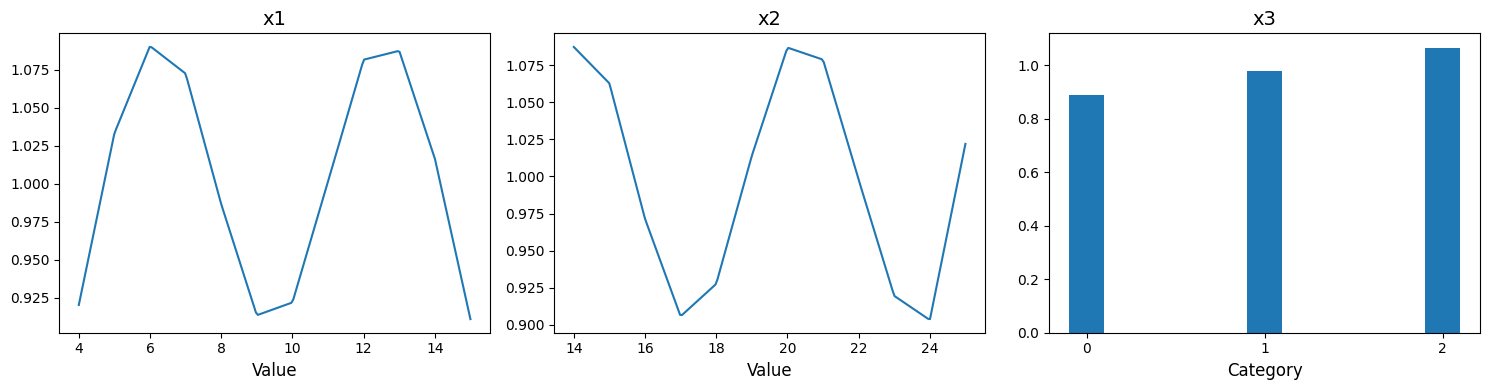

In [73]:
import matplotlib.ticker as mticker

n_features = len(feature_config)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

if n_rows * n_cols == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, (feature, transformer) in enumerate(feature_config.items()):
    ax = axes[i]  # pick the subplot for this feature

    if isinstance(transformer, OneHotEncoder):
        coef_dict = lprm_ols.coef_dict[feature]
        categories = []
        values = []
        for subfeature, coef in coef_dict.items():
            category = subfeature.split('_')[-1]
            categories.append(category)
            values.append(coef)
        ax.bar(categories, values, width=0.2)
        x_label = 'Category'
        
    if isinstance(transformer, FlatRampTransformer):
        # use the knots from the transformer and generate a smooth range for plotting
        knots = transformer.knots
        x_min, x_max = min(knots), max(knots)
        x_grid = np.linspace(x_min, x_max, 200).reshape(-1, 1)
        coef_vector = lprm_ols.coef_blocks[feature]
        transformed_x_grid = transformer.transform(x_grid)
        y_vals = transformed_x_grid @ coef_vector
        ax.plot(x_grid, y_vals)
        x_label = 'Value'

    ax.set_title( feature, fontdict={'fontsize': 14} )
    ax.set_xlabel( x_label, fontdict={'fontsize': 12} )
    
# hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


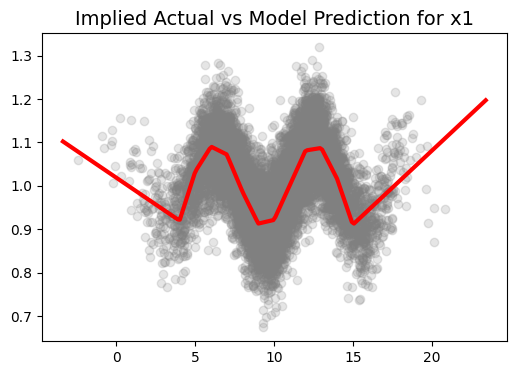

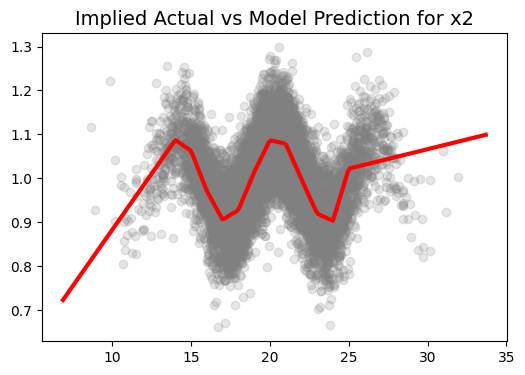

In [97]:
for feature, transformer in feature_config.items():
    if isinstance(transformer, FlatRampTransformer):
        sample_mask = np.random.rand(len(df)) < 0.1
        train_df_sample = train_df[sample_mask]
        df_sample = df[sample_mask]
        other_blocks_preds = lprm_ols.leave_out_feature_group_predict(feature, train_df_sample)
        implied_actual = df_sample['y'] / other_blocks_preds
        plt.figure(figsize=(6, 4))
        plt.scatter(df_sample[feature], implied_actual, alpha=0.2, color='grey')
        this_feature_coef = lprm_ols.coef_blocks[feature]
        x_min, x_max = df[feature].min(), df[feature].max()
        x_grid = np.linspace(x_min, x_max, 200).reshape(-1, 1)
        this_feature_preds = transformer.transform(x_grid) @ this_feature_coef
        plt.plot(x_grid, this_feature_preds, color='red', label='Model Prediction', linewidth=3)
        plt.title(f'Implied Actual vs Model Prediction for {feature}', fontdict={'fontsize': 14} )

In [75]:
lprm_ols.leave_out_feature_group_predict('x1', train_df)

array([10.09427338, 11.23335143, 12.23552286, ..., 11.90636319,
       11.43784054, 11.01959456], shape=(100000,))